# ADA Group 9 - Assignment 2

# Task

Use the One-piece [competition case](https://www.kaggle.com/t/f5f7783abf31495f9593b3d93a18f9eb).

1. Read the training sample to a Pandas dataframe.
1. Extending Assignment 1, now consider multiple linear regression models.
$$y=\beta_0+\beta_1x_1+\beta_2x_2+...+\beta_Kx_K + \epsilon$$
1. Choose **one** multiple linear regression model and make predictions from the test data set.
    - Clearly, model choice is an art now...
    - Possibly, use forward search or backward search,
    - or try Benjamini-Hochberg method,
    - or consider some K-fold method for model selection,
    - or use your experience to select key variables,
    - or eavesdrop your rivals,
    - or create new variables based on existing ones,
    - or Lasso it,
    - or some technique combination.
    - This is a typical example of open-ended questions.
1. Get the test sample for prediction and submit your results on Kaggle to get your Kaggle score screenshot. Show the screenshot in the PDF file.

## Install Packages

In [13]:
import pandas as pd
import numpy as np
import plotly.express as px # pyright: ignore[reportMissingImports] t
from sklearn.linear_model import Lasso, LinearRegression,LassoCV, ElasticNetCV # pyright: ignore[reportMissingModuleSource]
from sklearn.preprocessing import StandardScaler # pyright: ignore[reportMissingModuleSource]
from sklearn.model_selection import cross_val_score

## 1. Read Data

In [14]:
train_url = "https://github.com/joshcpld/ada/raw/main/Assignment%202/data/train_data.csv"
train_df = pd.read_csv(train_url)
train_df.head()

,ID,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,0,-1.399091,1.174139,1.413109,0.164693,-1.067338,0.015324,-1.280970,0.489681,-0.371982,0.781842,-1.210299,0.589132,1.772201,-1.639389,-0.834592,-0.901925,-0.343701,-0.093027,0.643531,0.349825,-0.827094,-0.075796,-0.420573,-0.524759,-0.275561,-0.890457,-0.148821,1.061241,-0.554413,1.123592,-0.349480,-0.688370,-2.034246,0.299572,0.549597,0.164273,0.272469,0.456102,-1.056807,-1.394984,2.014094,-0.115044,-2.580043,-0.812428,0.772820,-0.460444,0.190422,-0.362052,-1.119038,0.916313,-1.517434
1,1,3.097990,0.208922,0.931231,0.838779,0.893483,-0.510555,0.900289,-0.042490,0.839400,-1.379352,1.339519,-0.620785,-0.368221,0.234107,1.117305,-0.879327,0.445635,0.516927,-1.873290,-0.570796,-1.036694,-1.333672,0.078700,1.079935,-0.150720,-2.688285,1.203276,0.820444,-0.588538,-1.053576,0.682526,-2.120965,0.358839,0.300199,-1.350385,-0.274411,-0.613803,-0.657302,1.079090,-0.631399,0.412948,1.155635,0.673035,-0.438152,-0.001316,-0.761800,1.335092,0.901978,-1.549504,-0.456224,0.223405
2,2,-1.707346,-0.744982,0.962118,0.615392,-0.427943,-0.014912,1.138781,1.159491,0.055467,0.782026,0.158457,-1.439135,-1.870188,-1.202579,0.094862,-1.162649,0.958493,0.045562,-0.070664,0.766938,0.629026,-0.265813,0.349651,-1.753283,-1.344152,1.471223,-0.699141,-0.116345,-2.459410,0.669090,-1.501152,1.760160,-0.186497,1.075320,1.131879,-0.887702,0.632680,-1.337154,-0.972320,-0.228950,-0.572144,0.299277,1.387495,-0.007519,-0.464825,0.830986,0.373124,0.319232,-0.577295,-1.363846,-0.347154
3,3,0.610625,-0.170428,-1.361771,0.206042,0.623124,0.907441,-0.873814,1.287383,0.901191,1.239195,0.157426,-0.999241,0.318284,0.965701,0.897713,-0.757732,-1.505948,-0.276980,1.151711,-0.622249,-0.391593,0.664534,-1.183876,1.296685,-0.308810,-1.415345,-0.470508,-0.165303,1.567061,0.827487,-1.736215,0.606802,0.614855,0.046301,-0.801736,0.853164,-0.325791,0.025664,-0.193876,-0.835336,0.492473,1.209247,0.095866,-0.287905,-1.110714,-1.660352,0.207231,-0.419119,-0.517563,-1.050697,-0.096327
4,4,-0.689196,-0.858792,0.321308,-0.415649,1.014056,-0.522858,0.926634,-0.390663,0.790054,0.706096,0.060162,-0.711397,-0.141675,0.478967,2.567107,-1.829719,0.744514,2.006614,1.284232,-0.216585,1.282273,0.629702,-0.488080,1.161377,0.298775,-1.534104,-0.610331,1.239716,0.308757,1.185622,-0.052254,1.482354,0.364359,0.633992,-0.528211,0.382203,-0.344436,-0.043629,0.657528,0.661229,1.202661,-1.191989,-1.127448,0.246358,0.407769,1.132454,-0.016621,0.964745,0.091532,0.649593,-0.818020


## 2. LASSO Regularisation with K-fold CV

In this section, we begin with LASSO regularisation to reduce our parameter scope using cross-validation.

First, we scale the predictors to ensure comparability.

In [15]:
# Separate the X predictors and Y outcome variable
X0_train = train_df.drop(columns=['Y', 'ID'])
y0_train = train_df['Y'].values

# Scale the predictors
scaler = StandardScaler()
X1_train = scaler.fit_transform(X0_train)

Second, we select the 'optimal' alpha for LASSO regularisation (which we combine with cross-validation).

In [16]:
lasso_cv_model = LassoCV(alphas=np.logspace(-5, 2, num=100), cv=10, max_iter=10000)

# Fit the LassoCV model to the scaled training data
lasso_cv_model.fit(X1_train, y0_train)

# The optimal alpha selected by cross-validation
optimal_alpha_lasso = lasso_cv_model.alpha_
print("Optimal Alpha:", optimal_alpha_lasso)

Optimal Alpha: 0.034304692863149154


In [17]:
lasso_cv_model = Lasso(alpha=optimal_alpha_lasso)
lasso_cv_model.fit(X1_train, y0_train)
lasso_cv_model

,alpha,np.float64(0....4692863149154)
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


## 3. ElasticNet with K-fold CV

In this section, we expand on our use of LASSO by using ElasticNet. This essentially incorporates both LASSO and Ridge regression for parameter regularisation.

In [18]:
# elastic net and cross-validation
alphas = np.logspace(-5, 2, 100)  # Range of alpha values to test
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]  # Range of l1_ratio values to test
elastic_net = ElasticNetCV(alphas=np.logspace(-5, 2, 100), l1_ratio=l1_ratios, cv=10, max_iter=10000, n_jobs=-1)
elastic_net.fit(X1_train, y0_train)
best_alpha = elastic_net.alpha_
best_l1_ratio = elastic_net.l1_ratio_

# results
print(best_alpha, best_l1_ratio)

0.034304692863149154 1.0


Let us compare LASSO CV and ElasticNet CV to OLS on a graph to see the effects of regularisation.

In [19]:
# Get the coefficients and feature names for Lasso and ElasticNet
lasso_coefficients = lasso_cv_model.coef_
elastic_net_coefficients = elastic_net.coef_
feature_names = X0_train.columns

# Initialize the OLS regression model
ols_model = LinearRegression()
# Fit the OLS model to the training data
ols_model.fit(X1_train, y0_train)
# Get the coefficients for OLS
ols_coefficients = ols_model.coef_

# Create DataFrames for Lasso and OLS coefficients
lasso_coeff_df = pd.DataFrame({'Feature': feature_names, 'LASSO Coefficient': lasso_coefficients})
elastic_net_coeff_df = pd.DataFrame({'Feature': feature_names, 'ElasticNet Coefficient': elastic_net_coefficients})
ols_coeff_df = pd.DataFrame({'Feature': feature_names, 'OLS Coefficient': ols_coefficients})

# Combine the DataFrames
combined_coeff_df = pd.merge(ols_coeff_df, lasso_coeff_df, on='Feature')
combined_coeff_df = pd.merge(combined_coeff_df, elastic_net_coeff_df, on='Feature')

# Create an interactive scatter plot using Plotly
fig = px.scatter(combined_coeff_df, x='Feature', y=['OLS Coefficient', 'LASSO Coefficient', 'ElasticNet Coefficient'],
                 title='OLS vs LASSO vs ElasticNet Coefficients', labels={'value': 'Coefficient'})

# Customize layout
fig.update_layout(xaxis={'tickangle': -45, 'title': 'Feature'},
                  yaxis={'title': 'Coefficient'})

# Show the interactive plot
fig.show()

As can be observed, we still recover a majority of our parameters in both regularisation techniques.

## 4. Model Evaluation

In [20]:
lasso_cv_mse = -cross_val_score(
    lasso_cv_model, 
    X1_train, 
    y0_train,
    cv=10,
    scoring="neg_mean_squared_error"
)
print("Mean CV MSE:", np.mean(lasso_cv_mse))
print("Mean CV RMSE:", np.sqrt(np.mean(lasso_cv_mse)))

Mean CV MSE: 7.399768681029597
Mean CV RMSE: 2.720251584142466


In [21]:
elastic_net_cv_mse = -cross_val_score(
    elastic_net, 
    X1_train, 
    y0_train,
    cv=10,
    scoring="neg_mean_squared_error"
)

print("Mean CV MSE:", np.mean(elastic_net_cv_mse))
print("Mean CV RMSE:", np.sqrt(np.mean(elastic_net_cv_mse)))

Mean CV MSE: 7.411231813570614
Mean CV RMSE: 2.7223577673719914


Given that LASSO has a smaller MSE than Elastic Net, we use LASSO for our feature selection.

## 5. Model Estimation

In this section, we use LASSO to select our most relevant features and then estimate a multiple linear regression model based on the selected predictors.

In [22]:
# Create a dataframe with the LASSO coefficients and the 
LASSO_coef_df = pd.DataFrame({
    "Predictor": X0_train.columns,
    "Coefficient": lasso_cv_model.coef_
})

# Create a list of the predictors that are zero
LASSO_zero_predictors = LASSO_coef_df.loc[LASSO_coef_df["Coefficient"] == 0, "Predictor"].tolist()
LASSO_zero_predictors

['X2',
 'X4',
 'X7',
 'X8',
 'X13',
 'X17',
 'X24',
 'X29',
 'X33',
 'X42',
 'X44',
 'X45',
 'X50']

## 6. Model Prediction

In this section, we fit our multiple linear regression model after we remove the predictors which were shrunken to zero using LASSO.

In [23]:
# Read in the data and remove the predictors that have had their parameter shrunk to zero
test_url = "https://github.com/joshcpld/ada/raw/main/Assignment%202/data/test_data.csv"
test_df = pd.read_csv(test_url)
test_X0 = test_df.drop(columns=['ID', 'X2', 'X4', 'X7', 'X8', 'X13', 'X17', 'X24', 'X29', 'X33', 'X42', 'X44', 'X45', 'X50'])
train_OLS = train_df.drop(columns=['ID', 'Y', 'X2', 'X4', 'X7', 'X8', 'X13', 'X17', 'X24', 'X29', 'X33', 'X42', 'X44', 'X45', 'X50'])

# Fit an OLS model to our training data
ols_model.fit(train_OLS, y0_train)

# Predict the Y values using the OLS model
Y_pred = ols_model.predict(test_X0)

# Create the data frame with each ID and the predicted Y value
test_df['Y_pred'] = Y_pred
pred_df = test_df[['ID', 'Y_pred']]

# Print out the OLS coefficients
OLS_coef_df = pd.DataFrame({
    "Predictor": train_OLS.columns,
    "Coefficient": ols_model.coef_
})

OLS_coef_df.sort_values(by="Coefficient", ascending=False).reset_index().drop('index', axis=1)

,Predictor,Coefficient
0,X34,1.183642
1,X41,0.712024
2,X48,0.594443
3,X26,0.573359
4,X16,0.573280
5,X1,0.559206
6,X10,0.545111
7,X46,0.520788
8,X22,0.488262
9,X15,0.485294


In [24]:
# Export predictions to submission file
submission_ass2 = pd.read_csv('../data/submission.csv')
submission_ass2['Y'] = pred_df[['Y_pred']].values
submission_ass2.to_csv("submission_ass2_group9.csv", index=False)

## Leaderboard Screenshot

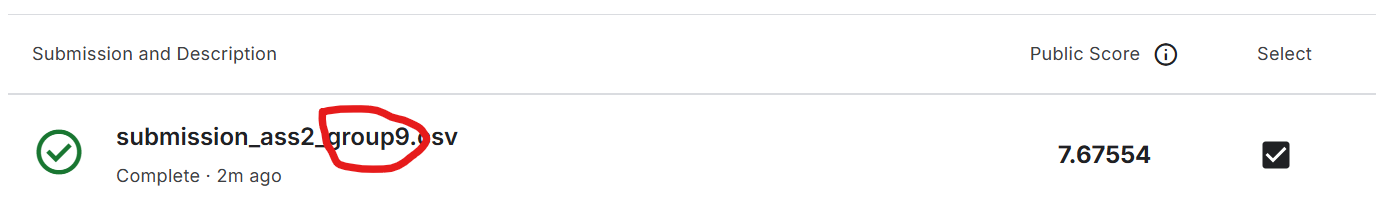